# Malawi PMT Analysis Expanded Dataset Workbook

This workbook contains the analysis of the expanded dataset, including variables that wouldn't normally be included in a PMT due to the difficulty an enumerator would have in verifying them.


In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect display width
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple pages

# Jupyter display options
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Function Appendix

In [20]:
def make_r2_by_feature_count_plot(dataset, eval_on_urban_only=False, expanded_data=False):
    # List of R^2 columns to process
    models = ["Stepwise", "RandomForest", "GradientBoosting", "Lasso"]
    r2_df = None
    for model in models:
        if eval_on_urban_only:
            if expanded_data:
                model_df = pd.read_csv(f"x02_ml_pipeline/output/{dataset}/r2_{model}_eval_on_urban_expanded.csv")
            else:
                model_df = pd.read_csv(f"x02_ml_pipeline/output/{dataset}/r2_{model}_eval_on_urban.csv")
        else:
            if expanded_data:
                model_df = pd.read_csv(f"x02_ml_pipeline/output/{dataset}/r2_{model}_expanded.csv")
            else:
                model_df = pd.read_csv(f"x02_ml_pipeline/output/{dataset}/r2_{model}.csv")
        # model_df = model_df.rename(columns={"Train R^2": f"{model} Train R^2", "Test R^2": f"{model} Test R^2"})
        model_df = model_df.drop(columns=["Selected Variables"])
        model_df['Model'] = model
        if r2_df is None:
            r2_df = model_df
        else:
            r2_df = pd.concat([r2_df, model_df], axis=0)
            
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Define colors for each model
    colors = {
        "Stepwise": "#3366CC",
        "RandomForest": "#109618",
        "GradientBoosting": "#DC3912",
        "Lasso": "#990099"
    }
    
    # Plot each model's train and test R^2
    for model in models:
        model_data = r2_df[r2_df['Model'] == model]
        plt.plot(model_data["Number of Features"], model_data["Train R^2"], 
                 color=colors[model], label=f"{model} Train", linewidth=2)
        plt.plot(model_data["Number of Features"], model_data["Test R^2"], 
                 color=colors[model], label=f"{model} Test", linewidth=2, linestyle='--')
    
    # Customize the plot
    plt.xlabel("Number of Features")
    plt.ylabel("R^2 Score")
    if eval_on_urban_only:
        if expanded_data:
            plt.title(f"R^2 Scores by Number of Features for {dataset.capitalize()} Expanded Dataset (Test on Urban Only)")
        else:
            plt.title(f"R^2 Scores by Number of Features for {dataset.capitalize()} Dataset (Test on Urban Only)")
    else:
        if expanded_data:
            plt.title(f"R^2 Scores by Number of Features for {dataset.capitalize()} Expanded Dataset")
        else:
            plt.title(f"R^2 Scores by Number of Features for {dataset.capitalize()} Dataset")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(0,1)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

def coalesce_vars(df, col_name_prefix):
    selected_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    df[col_name_prefix] = df[selected_cols].bfill(axis=1).iloc[:, 0]
    df = df.drop(columns=selected_cols)
    return df

def pretty_print_fi_table(fi_df):
    fi_df["fi_values"] = fi_df["fi_values"].apply(abs)
    # Determine the maximum number of features
    max_vars = fi_df["num_vars"].max()
    
    # Define the steps we want to show (6, 11, 16, 21, ...)
    steps = np.arange(6, max_vars + 1, 5)
    
    # If the max number of variables is not in steps, add it
    if max_vars not in steps:
        steps = np.append(steps, max_vars)
    
    # Create a new DataFrame to store the results
    result = pd.DataFrame(index=fi_df.columns)
    
    sub_dfs = []
    for step in steps:
        # Get the rows for this number of variables
        sub_df = fi_df[fi_df["num_vars"] == step]
        
        # Sort variables by importance
        sub_df = sub_df.sort_values(by="fi_values", ascending=False)
        sub_df = sub_df.rename(columns={"fi_values": f"Importance ({step})", "var_names": f"Variable ({step})", "num_vars": f"num_vars ({step})"})
        sub_dfs.append(sub_df)
    
    result = pd.concat(sub_dfs, axis=1)
    result = coalesce_vars(result, "Variable")
    result = coalesce_vars(result, "num_vars")

    result.index = result["Variable"]
    def combine_rows(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan
    collapsed_df = result.groupby(level=0).agg(combine_rows)
    collapsed_df = collapsed_df.sort_values(by=f"Importance ({max_vars})", ascending=False)
    collapsed_df = collapsed_df.drop(columns=["Variable", "num_vars"])
    collapsed_df = collapsed_df.applymap(lambda x: "" if np.isnan(x) else x)
    collapsed_df = collapsed_df.drop(index=["const"])
    return collapsed_df

def round_helper(x):
    try:
        return round(float(x), 3)
    except:
        return x

def pretty_print_summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    df["mean"] = df["mean"].apply(round_helper)
    df["std"] = df["std"].apply(round_helper)
    df["Missing Fraction before Imputation/Dummying"] = df["Missing Fraction before Imputation/Dummying"].apply(round_helper)
    column_mapping = {
        "hh_f05": "Age of dwelling",
        "hh_f10": "Number of rooms",
        "hh_f34": "Number of cell phones",
        "hh_h02a": "Number of days in last seven relied on less preferred food",
        "hh_h02b": "Number of days in last seven limited portion size",
        "hh_h02c": "Number of days in last seven reduced number of meals",
        "hh_h02d": "Number of days in last seven restricted consumption for adults",
        "hh_h02e": "Number of days in last seven restricted borrowed food",
        "hh_h03a": "Meals per day",
        "hh_h03b": "Meals per day (children 5-17)",
        "hh_h03c": "Meals per day (children 6-59 months)"
    }
    df["covariate"] = df["covariate"].apply(lambda x: column_mapping.get(x, x))
    df.set_index("covariate", inplace=True)
    return df

# Summary Tables

### All Data

In [21]:
df = pd.read_csv('x01_ingest_data/output/post_encoding_summary_expanded.csv')
pretty_print_summary_stats(df)

,mean,std,Missing Fraction before Imputation/Dummying
covariate,,,
case_id,101011000014.0,0.000,0.000
hh_wgt,502.734,260.338,0.000
outcome,2.403,2.665,0.000
hhid,0004806a172546e99ae07674de291ed7,0.000,0.000
pid,1.02,0.219,0.000
durable_asset_Air conditioner,0.001,0.040,0.000
durable_asset_Bed,0.548,1.055,0.000
durable_asset_Beer-brewing drum,0.018,0.179,0.000
durable_asset_Bicycle,0.415,0.649,0.000


## Urban Only

In [22]:
df = pd.read_csv('x01_ingest_data/output/post_encoding_summary_urban_expanded.csv')
pretty_print_summary_stats(df)

,mean,std,Missing Fraction before Imputation/Dummying
covariate,,,
case_id,101201220032.0,0.000,0.000
hh_wgt,462.562,219.050,0.000
outcome,4.406,4.936,0.000
hhid,0034c13e91014cb0b1daf791fdea88be,0.000,0.000
pid,1.022,0.157,0.000
durable_asset_Air conditioner,0.006,0.085,0.000
durable_asset_Bed,1.449,1.629,0.000
durable_asset_Beer-brewing drum,0.018,0.216,0.000
durable_asset_Bicycle,0.316,0.638,0.000


## Rural Only

In [23]:
df = pd.read_csv('x01_ingest_data/output/post_encoding_summary_rural_expanded.csv')
pretty_print_summary_stats(df)

,mean,std,Missing Fraction before Imputation/Dummying
covariate,,,
case_id,101011000014.0,0.000,0.000
hh_wgt,510.518,266.904,0.000
outcome,2.015,1.681,0.000
hhid,0004806a172546e99ae07674de291ed7,0.000,0.000
pid,1.019,0.230,0.000
durable_asset_Air conditioner,0.0,0.023,0.000
durable_asset_Bed,0.374,0.791,0.000
durable_asset_Beer-brewing drum,0.018,0.171,0.000
durable_asset_Bicycle,0.434,0.649,0.000


# Machine Learning Model Performance

## Train-on-all-data, test-on-all-data

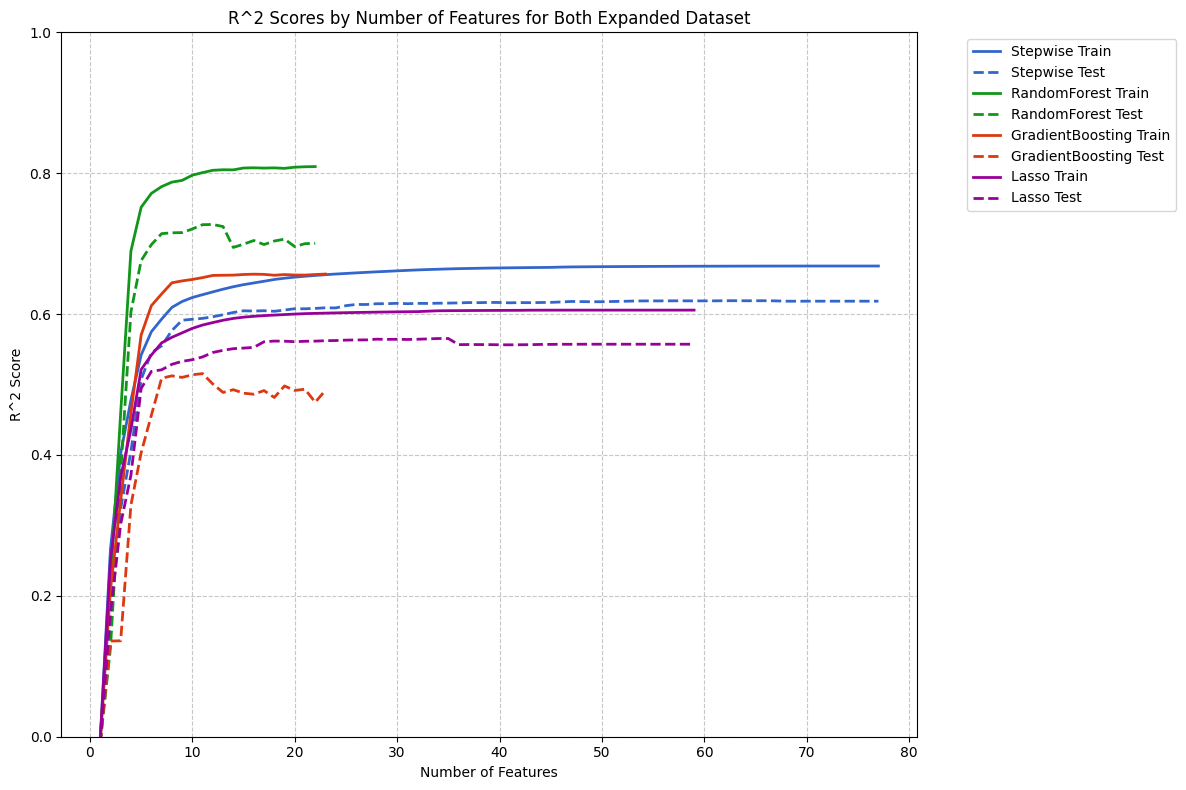

In [24]:
make_r2_by_feature_count_plot("both", False, True)

Gradient boosting does best here by a long shot.

In [33]:
r2_df = pd.read_csv('x02_ml_pipeline/output/both/r2_GradientBoosting_expanded.csv', index_col=0)
r2_df = r2_df.sort_values(by="Test R^2", ascending=False)
r2_df.iloc[0]

Train R^2                                                                                                                                                                                                                                     0.651787
Test R^2                                                                                                                                                                                                                                      0.515485
Selected Variables    ['const', 'hh_f12_GAS', 'durable_asset_Computer equipment & accessories', 'hhsize', 'durable_asset_Electric Kettle', 'hh_f09_SMOOTH CEMENT', 'hh_f34', 'hh_h04_YES', 'hh_f43_PUBLIC RUBBISH HEAP', 'hh_c09_3.0', 'hh_f08_GRASS']
Name: 11, dtype: object

In [26]:
fi = pd.read_csv('x02_ml_pipeline/output/both/importances_GradientBoosting_expanded.csv', index_col=0)
pretty_print_fi_table(fi)

/data/tmp/ipykernel_214893/1009513821.py:105: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  collapsed_df = collapsed_df.applymap(lambda x: "" if np.isnan(x) else x)


,Importance (6),Importance (11),Importance (16),Importance (21),Importance (23)
Variable,,,,,
hhsize,0.346,0.296,0.294,0.293,0.294
durable_asset_Computer equipment & accessories,0.331,0.272,0.272,0.271,0.271
hh_f09_SMOOTH CEMENT,0.163,0.136,0.136,0.136,0.135
hh_f34,,0.113,0.11,0.11,0.108
durable_asset_Electric Kettle,0.091,0.066,0.063,0.064,0.063
hh_f12_GAS,0.069,0.057,0.057,0.057,0.057
hh_h04_YES,,0.031,0.031,0.031,0.031
hh_f43_PUBLIC RUBBISH HEAP,,0.013,0.013,0.013,0.013
hh_f08_GRASS,,0.008,0.008,0.008,0.008


## Train-on-all-data, test-on-urban-only

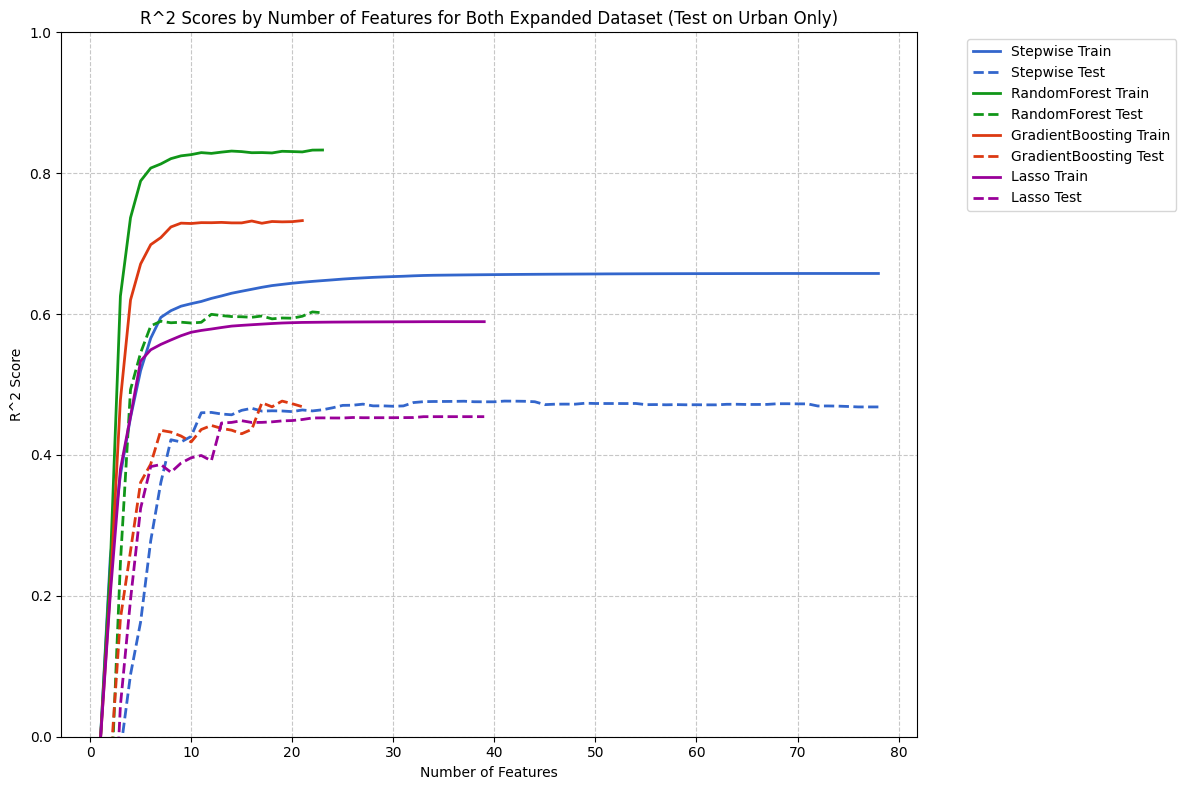

In [27]:
make_r2_by_feature_count_plot("both", True, True)

Random forest does better here, even if I don't believe the results b/c test does better than train.

In [28]:
r2_df = pd.read_csv('x02_ml_pipeline/output/both/r2_RandomForest_eval_on_urban_expanded.csv', index_col=0)
r2_df = r2_df.sort_values(by="Test R^2", ascending=False)
r2_df.iloc[0]

Train R^2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                0.832801
Test R^2                                                                                                                                                                                                                                                                                                                                                                                                              

In [29]:
fi = pd.read_csv('x02_ml_pipeline/output/both/importances_RandomForest_eval_on_urban_expanded.csv', index_col=0)
pretty_print_fi_table(fi)

/data/tmp/ipykernel_214893/1009513821.py:105: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  collapsed_df = collapsed_df.applymap(lambda x: "" if np.isnan(x) else x)


,Importance (6),Importance (11),Importance (16),Importance (21),Importance (23)
Variable,,,,,
hhsize,0.397,0.367,0.342,0.331,0.328
durable_asset_Car,0.288,0.262,0.259,0.254,0.249
hh_f12_COLLECTED FIREWOOD,0.118,0.115,0.107,0.106,0.105
hh_f34,0.113,0.101,0.082,0.077,0.074
durable_asset_Electric Kettle,0.084,0.077,0.059,0.061,0.051
hh_h03b,,,0.043,0.043,0.044
durable_asset_Desk,,0.037,0.037,0.033,0.034
hh_f11_BATTERY/DRY CELL(TORCH),,,0.036,0.034,0.033
hh_h01_YES,,,,,0.025


## Train-on-urban-only, test-on-urban-only

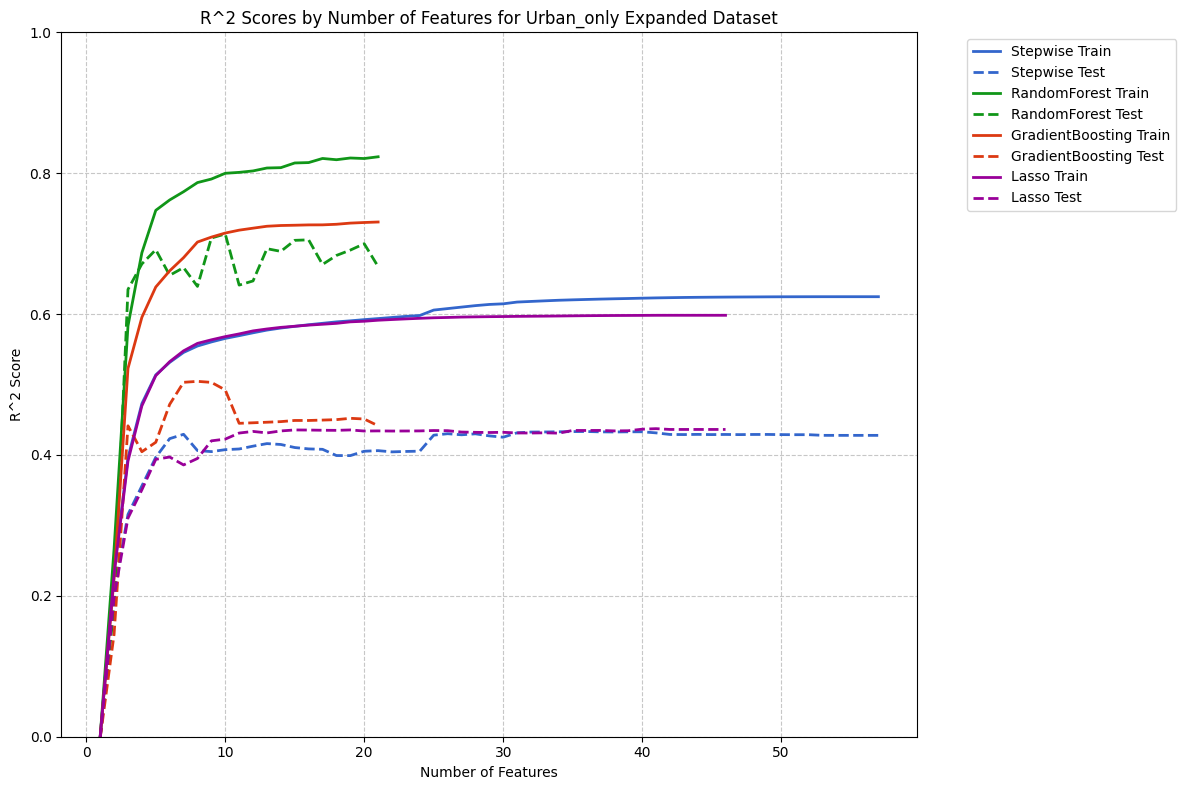

In [30]:
make_r2_by_feature_count_plot("urban_only", False, True)

In [31]:
r2_df = pd.read_csv('x02_ml_pipeline/output/urban_only/r2_RandomForest_expanded.csv', index_col=0)
r2_df = r2_df.sort_values(by="Test R^2", ascending=False)
r2_df.iloc[0]

Train R^2                                                                                                                                                                                                                0.799897
Test R^2                                                                                                                                                                                                                 0.713757
Selected Variables    ['const', 'hh_t06', 'durable_asset_Car', 'durable_asset_Computer equipment & accessories', 'hh_f19_YES', 'hh_f09_TILE', 'hh_h03b', 'hh_head_has_cellphone_2', 'durable_asset_Sattelite dish', 'num_adults']
Name: 10, dtype: object

In [32]:
fi = pd.read_csv('x02_ml_pipeline/output/urban_only/importances_RandomForest_expanded.csv', index_col=0)
pretty_print_fi_table(fi)

/data/tmp/ipykernel_214893/1009513821.py:105: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  collapsed_df = collapsed_df.applymap(lambda x: "" if np.isnan(x) else x)


,Importance (6),Importance (11),Importance (16),Importance (21)
Variable,,,,
durable_asset_Car,0.362,0.318,0.281,0.282
hh_t06,0.435,0.343,0.278,0.278
hh_c09_8.0,,,0.07,0.068
durable_asset_Computer equipment & accessories,0.117,0.083,0.079,0.067
num_adults,,0.061,0.058,0.060
hh_f19_YES,0.055,0.049,0.047,0.045
hh_f43_PUBLIC RUBBISH HEAP,,0.04,0.027,0.038
"durable_asset_Upholstered chair, sofa set",,,0.044,0.033
durable_asset_Sattelite dish,,0.048,0.034,0.030
